## Example of how to generate simulated data using DiffSimGen

In [1]:
from diffsimgen import diffsimrun
import numpy as np
import matplotlib.pyplot as plt

/home/ROBARTS/bkarat/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Lets take a look at the function diffsimrun

In [2]:
help(diffsimrun)

Help on function diffsimrun in module diffsimgen.diffsimrun:

diffsimrun(model, bval, bvec, SNR, output=None, numofsim=100000, noise_type='rician', delta=None, Delta=None, TE=None, parameter_distributions=[])
    Function for generating training data (signal and microstructure parameters)
    Current models accepted:
    - NODDI_watson
    - ball
    - stick
    - ball_stick
    - zeppelin
    bval: str or array (N,)
      path to .bval file or numpy array with bvalues.
    bvec: str or array (N,3)
      path to .bvec file or numpy array with bvectors.
    output: str
      Output path/filename for saving as a .pkl. If none specified saves in 
      current working directory.
    SNR: float or array
      Signal to noise ratio. Example -> 40, [10,50], [10,20,30,40,50]
      If you specify two SNR values ([10,100])
      then a random SNR value will be drawn within that range with equal probability.
      This can help if you want to cover the range of signals that might be present
    

#### Can see our diffusion acquisition has 266 measurements

In [3]:
bvals = np.loadtxt('datasets/tutorial_dwi.bval')
bvecs = np.loadtxt('datasets/tutorial_dwi.bvec')
bvals.shape

(266,)

#### In this example we simulate data using the NODDI watson model

In [4]:
signal, noiseless_signal, parameters, parameter_names, SNRarr = diffsimrun(model='NODDI_watson',bval=bvals,bvec=bvecs,SNR=[50,100],numofsim=1000)

Converting bvalues to s/m^2


#### Here are the NODDI-defined microstructural parameters we simulated with

In [6]:
print(parameter_names)

['theta', 'phi', 'ODI', 'stick_fraction_within_watson', 'ball_fraction', 'total_watson_fraction']


#### We now have our simulated signal across 10000 different random microstructural environments defined by NODDI

In [7]:
signal.shape

(1000, 266)

#### This contains the 1000 random microstructural parameters used to simulate signal

In [7]:
parameters.shape

(1000, 6)

### Lets now check out a signal plot from two different simulated microstructural environments

In [33]:
print(f'microstructural environment #1 (high free diffusion):')
for ii in range(4):
    ii = ii+1
    print(f'{parameter_names[-ii]} = {parameters[1,-ii]}')

print(f'microstructural environment #2 (high restricted diffusion):')
for ii in range(4):
    ii = ii+1
    print(f'{parameter_names[-ii]} = {parameters[2,-ii]}')

microstructural environment #1 (high free diffusion):
total_watson_fraction = 0.08666370578231841
ball_fraction = 0.9133362942176816
stick_fraction_within_watson = 0.7745842594764226
ODI = 0.7704539226117512
microstructural environment #2 (high restricted diffusion):
total_watson_fraction = 0.9439228492545744
ball_fraction = 0.05607715074542562
stick_fraction_within_watson = 0.29275266956584434
ODI = 0.8623487757942124


##### Powder average data within each shell

In [34]:
bunique = np.unique(bvals)
s1 = np.zeros((len(bunique)))
s2 = np.zeros((len(bunique)))

for ii in range(len(bunique)):
    bind = bvals == bunique[ii]
    s1[ii] = np.mean(signal[1,bind])
    s2[ii] = np.mean(signal[2,bind])

##### Fitting monoexponential function to data

In [35]:
from scipy.optimize import curve_fit
# Function to calculate the exponential with constants a and b
def monoexp(x, m, t):
    return m * np.exp(-t * x)

barray = np.linspace(0,6000,100)

p0 = (1,0.0000003 ) # start with values near those we expect

params1,cv = curve_fit(monoexp,bunique,s1,p0)
params2,cv = curve_fit(monoexp,bunique,s2,p0)

s1fit = monoexp(barray,params1[0],params1[1])
s2fit = monoexp(barray,params2[0],params2[1])

### As expected, the more "free" environment has a lower signal, given by the fact that water can diffuse further in that environment. As well, the "free" signal decays much faster than the "restricted" signal, in line with the idea that the intracellular signal dominates at higher b-values 

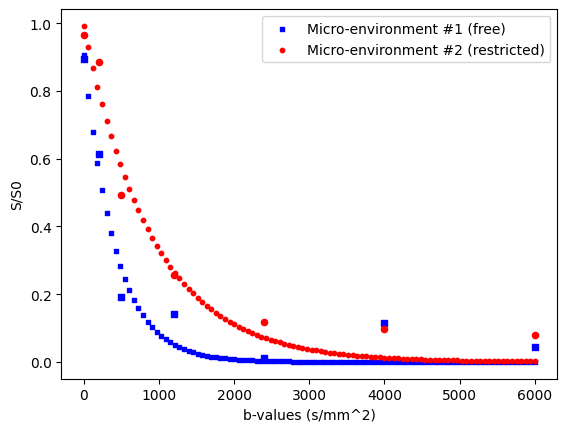

In [37]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(barray, s1fit, s=10, c='b', marker="s", label='Micro-environment #1 (free)')
ax1.scatter(barray,s2fit, s=10, c='r', marker="o", label='Micro-environment #2 (restricted)')
ax1.scatter(bunique, s1, s=20, c='b', marker="s")
ax1.scatter(bunique,s2, s=20, c='r', marker="o")
plt.legend(loc='upper right')
plt.xlabel("b-values (s/mm^2)")
plt.ylabel("S/S0")
plt.show()